In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from transformers import (
    XLMRobertaTokenizer,
    XLMRobertaForSequenceClassification,
    get_scheduler
)
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# IHQID_1mg_train_path = "indic-health-demo/Dataset/IHQID-1mg/train.csv"
# IHQID_1mg_test_path = "indic-health-demo/Dataset/IHQID-1mg/test.csv"

IHQID_WebMD_train_path = "indic-health-demo/Dataset/IHQID-WebMD/train.csv"
IHQID_WebMD_test_path = "indic-health-demo/Dataset/IHQID-WebMD/test.csv"

IHQID_train = pd.read_csv(IHQID_WebMD_train_path)[['question_hindi', 'Manual_Intent']]
IHQID_test = pd.read_csv(IHQID_WebMD_test_path)[['question_hindi', 'Manual_Intent']]

IHQID_train['Manual_Intent_Encoded'] = IHQID_train['Manual_Intent']
IHQID_test['Manual_Intent_Encoded'] = IHQID_test['Manual_Intent']

label_encoder = LabelEncoder()
label_encoder.fit(IHQID_train['Manual_Intent_Encoded'])

IHQID_train['Manual_Intent_Encoded'] = label_encoder.transform(IHQID_train['Manual_Intent_Encoded'])
IHQID_test['Manual_Intent_Encoded'] = label_encoder.transform(IHQID_test['Manual_Intent_Encoded'])


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Forcefully using cpu as model was not fitting in gpu
device = 'cpu'
print(device)

model_checkpoint = "xlm-roberta-base"

hyper_parameters = {
    'batch_size': 8,
    'lr': 3e-5,
    'epochs': 10
}

cpu


In [4]:
tokenizer = XLMRobertaTokenizer.from_pretrained(model_checkpoint)

encoded_input_train = tokenizer.batch_encode_plus(
    IHQID_train['question_hindi'],
    add_special_tokens=True,
    truncation=True,
    padding='max_length',
    return_tensors='pt'
)

encoded_input_test = tokenizer.batch_encode_plus(
    IHQID_test['question_hindi'],
    add_special_tokens=True,
    truncation=True,
    padding='max_length',
    return_tensors='pt'
)

train_dataloader = DataLoader(
    TensorDataset(
        encoded_input_train['input_ids'].to(device),
        encoded_input_train['attention_mask'].to(device),
        torch.tensor(IHQID_train['Manual_Intent_Encoded']).to(device)
    ),
    batch_size=hyper_parameters['batch_size']
)

test_dataloader = DataLoader(
    TensorDataset(
        encoded_input_test['input_ids'].to(device),
        encoded_input_test['attention_mask'].to(device),
        torch.tensor(IHQID_test['Manual_Intent_Encoded']).to(device)
    ),
    batch_size=hyper_parameters['batch_size']
)


In [5]:
model = XLMRobertaForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_encoder.classes_)
)
model.to(device)

optimizer = AdamW(
    model.parameters(),
    lr=hyper_parameters['lr']
)

lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=0,
  num_training_steps=hyper_parameters['epochs'] * len(train_dataloader)
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model.train()

updater = tqdm(range(hyper_parameters['epochs']))
for epoch in updater:
    total_train_loss = 0.0
    for batch in train_dataloader:
        
        optimizer.zero_grad()
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }
        
        outputs = model(**inputs)
        
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        
        total_train_loss += loss.item()
    
    print("Epoch:", epoch + 1, " - Training Loss:", round(total_train_loss / len(train_dataloader), 4))


# Didn't have much time to implement early stopping. So, saving the model at the end of all epochs.
torch.save(model.state_dict(), f'ir_xlmr_hi.model')


 10%|████▎                                      | 1/10 [04:47<43:10, 287.84s/it]

Epoch: 1  - Training Loss: 1.3841


 20%|████████▌                                  | 2/10 [09:43<38:59, 292.44s/it]

Epoch: 2  - Training Loss: 1.3809


 30%|████████████▉                              | 3/10 [14:27<33:40, 288.63s/it]

Epoch: 3  - Training Loss: 1.4069


 40%|█████████████████▏                         | 4/10 [19:16<28:52, 288.67s/it]

Epoch: 4  - Training Loss: 1.3895


 50%|█████████████████████▌                     | 5/10 [24:02<23:59, 287.81s/it]

Epoch: 5  - Training Loss: 1.3806


 60%|█████████████████████████▊                 | 6/10 [28:49<19:09, 287.43s/it]

Epoch: 6  - Training Loss: 1.3629


 70%|██████████████████████████████             | 7/10 [33:35<14:20, 286.96s/it]

Epoch: 7  - Training Loss: 1.3935


 80%|██████████████████████████████████▍        | 8/10 [38:20<09:33, 286.55s/it]

Epoch: 8  - Training Loss: 1.3786


 90%|██████████████████████████████████████▋    | 9/10 [43:07<04:46, 286.51s/it]

Epoch: 9  - Training Loss: 1.3001


100%|██████████████████████████████████████████| 10/10 [48:01<00:00, 288.13s/it]

Epoch: 10  - Training Loss: 1.2242


In [7]:
model.eval()

prediction = []
gold_label = []

for batch in test_dataloader:

    inputs = {
        'input_ids': batch[0],
        'attention_mask': batch[1],
        'labels': batch[2],
    }

    with torch.no_grad():
        outputs = model(**inputs)


    gold_label_cpu = inputs['labels'].cpu().numpy()
    logits_vector = outputs.logits.detach().cpu().numpy()

    assert(len(gold_label_cpu) == len(logits_vector))

    for index in range(len(logits_vector)):
        prediction.append(logits_vector[index].argmax(axis=0))
        gold_label.append(gold_label_cpu[index])

print(classification_report(gold_label, prediction))


              precision    recall  f1-score   support

           0       0.38      0.47      0.42        76
           1       0.58      0.60      0.59        53
           2       0.58      0.73      0.64        73
           3       0.00      0.00      0.00        39

    accuracy                           0.50       241
   macro avg       0.39      0.45      0.41       241
weighted avg       0.42      0.50      0.46       241



/home/naqueer_am/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/naqueer_am/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/naqueer_am/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


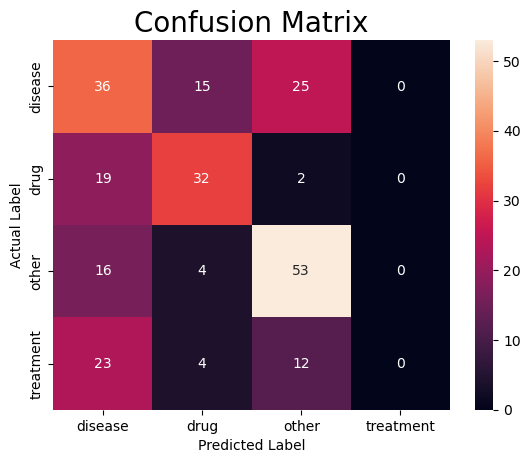

In [8]:
# Compute the confusion matrix
cm = confusion_matrix(gold_label, prediction)

# Plot the confusion matrix.
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    xticklabels=['disease', 'drug', 'other', 'treatment'],
    yticklabels=['disease', 'drug', 'other', 'treatment']
)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('Actual Label', fontsize=10)
plt.title('Confusion Matrix', fontsize=20)
plt.show()